In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Read data from directory
data_train,data_test = tf.keras.preprocessing.image_dataset_from_directory(
    "images_original", image_size=(256, 256), batch_size=32,
    seed=1,validation_split=0.2,subset="both"
)
print("Type of train data",type(data_train))
print("Type of test data",type(data_test))

Found 999 files belonging to 10 classes.
Using 800 files for training.
Using 199 files for validation.
Type of train data <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Type of test data <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [3]:
#check shape of data in first batch of train data
for dat_img, dat_label in data_train.take(1):
    print("Shape of image data in first batch of training data",dat_img.shape)
    print("Shape of label data in first batch of training data",dat_label.shape)

Shape of image data in first batch of training data (32, 256, 256, 3)
Shape of label data in first batch of training data (32,)


In [4]:
#check shape of data in first batch of test data
for dat_img, dat_label in data_test.take(1):
    print("Shape of image data in first batch of test data",dat_img.shape)
    print("Shape of label data in first batch of test data",dat_label.shape)

Shape of image data in first batch of test data (32, 256, 256, 3)
Shape of label data in first batch of test data (32,)


In [5]:
#check class/label names
class_names_test = data_test.class_names
print("Labels or classes in test data:",class_names_test)
class_names = data_train.class_names
print("Labels or classes in train data:",class_names)

Labels or classes in test data: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Labels or classes in train data: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


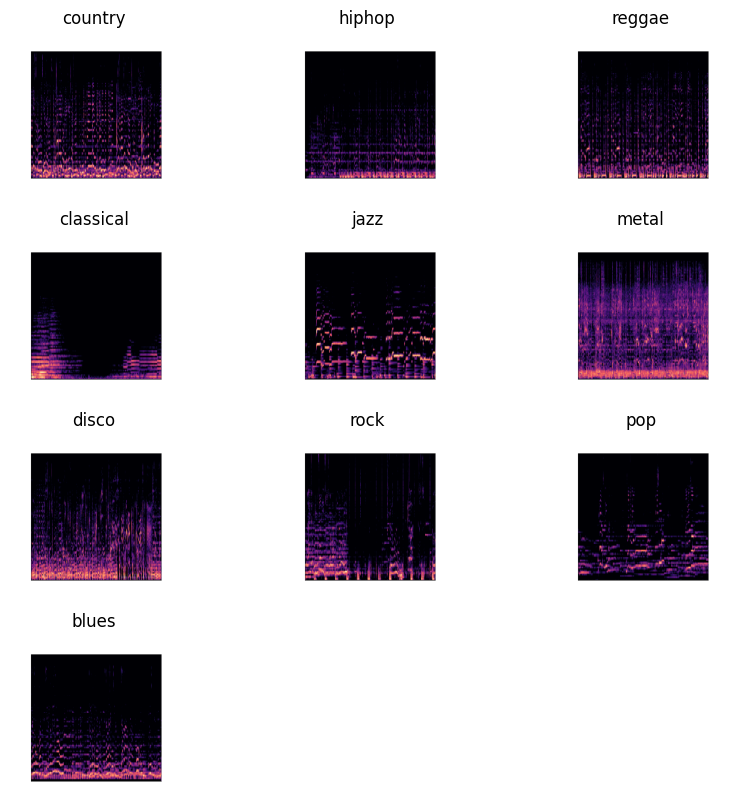

In [6]:
#plot one image for each class
plt.figure(figsize=(10, 10))
lst_plotted=[]
i=1
j=0
for img, lbl in data_train.take(i):
    for k in range(32):
        if class_names[lbl[k]] not in lst_plotted:
            ax = plt.subplot(4, 3, j + 1)
            j+=1
            plt.imshow(img[k].numpy().astype("uint8"))
            plt.title(class_names[lbl[k]])
            plt.axis("off")
            lst_plotted.append(class_names[lbl[k]])  
    i+=1
    if len(lst_plotted)>=10:
        break

In [7]:
#TFDS provide images of type tf.uint8, while the model expects tf.float32. 
#Normalize images.
def normalize_image(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [8]:
#num_parallel_calls loads multiple datasets in parallel, reducing the time waiting for the files to be opened.
data_train = data_train.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
data_test = data_test.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
#Good practice to end the pipeline by prefetching for performance.
data_train = data_train.prefetch(tf.data.AUTOTUNE)
data_test = data_test.prefetch(tf.data.AUTOTUNE)

In [10]:
#recheck train data shape
for dat_img, dat_label in data_train.take(1):
    print(dat_img.shape)
    print(dat_label.shape)

(32, 256, 256, 3)
(32,)


In [11]:
#recheck test data shape
for dat_img, dat_label in data_test.take(1):
    print(dat_img.shape)
    print(dat_label.shape)

(32, 256, 256, 3)
(32,)


In [12]:
num_classes = 10

In [13]:
#Function to create first dcnn model
def create_fit_cnn(prm_epochs):
    model = keras.Sequential(
        [
            keras.Input(shape=(256, 256, 3)),
            layers.Conv2D (16, kernel_size=(3, 3), activation="relu"),        
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.10),
            layers.Conv2D (32, kernel_size=(3, 3), activation="relu"),        
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.10),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),        
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.10),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    print(model.summary())
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)
    history = model.fit(data_train, epochs=prm_epochs, validation_data=data_test)
    return model,history

In [14]:
#Model accuracy
def print_accuracy(prm_history):
    print("\nModel history keys:",prm_history.history.keys())
    print("\nAccuracy:",prm_history.history['sparse_categorical_accuracy'])
    print("Validation Accuracy:",prm_history.history['val_sparse_categorical_accuracy'])

In [15]:
#plot model accuracy
def plot_modelAccuracy(prm_history):
    plt.plot(prm_history.history['sparse_categorical_accuracy'])
    plt.plot(prm_history.history['val_sparse_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [16]:
#plot model loss
def plot_modelLoss(prm_history):
    plt.plot(prm_history.history['loss'])
    plt.plot(prm_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [17]:
#Calculate confusion matrix
def calculate_confusion_matrix(prm_model):
    predicted_y = np.array([])
    test_y =  np.array([])
    for img, lbl in data_test:
        predicted_y = np.concatenate([predicted_y, np.argmax(prm_model(img), axis = -1)])
        test_y = np.concatenate([test_y, lbl.numpy()])
    cf_matrix=tf.math.confusion_matrix(labels=test_y, predictions=predicted_y).numpy()
    print(cf_matrix)
    return cf_matrix

In [18]:
#Plot confusion matrix
def plot_confusion_matrix(cf_matrix):
    fig, ax = plt.subplots(figsize=(9,7))  
    ax = sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu',linewidths=1, fmt='g', ax=ax)
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');
    #Set tick labels
    ax.xaxis.set_ticklabels(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
    ax.yaxis.set_ticklabels(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])
    plt.yticks(rotation=0) 
    plt.xticks(rotation=45) 
    plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

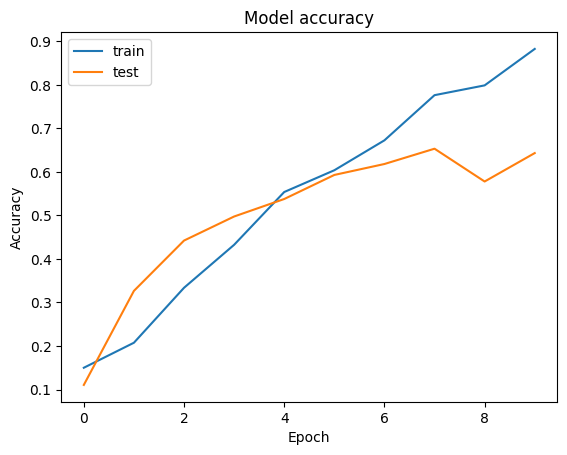

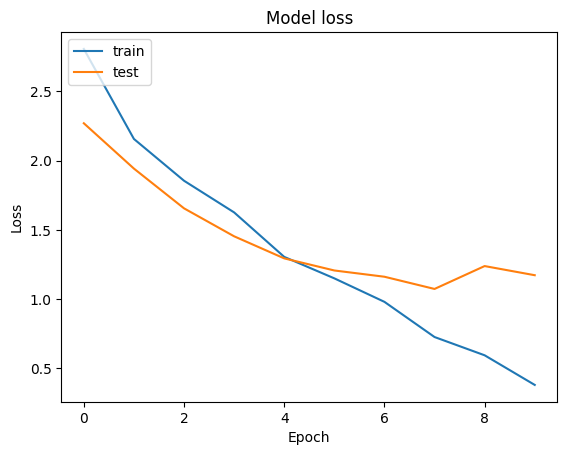

[[ 7  1  0  1  1  3  1  0  0  3]
 [ 0 17  0  0  0  0  0  1  0  1]
 [ 3  0  7  2  0  6  0  0  1  2]
 [ 0  0  1  8  2  0  0  4  2  3]
 [ 1  0  0  0 14  0  0  0  4  1]
 [ 1  2  0  0  0 18  0  1  0  0]
 [ 0  0  0  0  1  0 20  0  0  0]
 [ 2  1  0  1  2  1  0 12  0  2]
 [ 1  0  2  0  0  0  0  2 10  0]
 [ 1  0  1  0  2  0  1  2  1 15]]


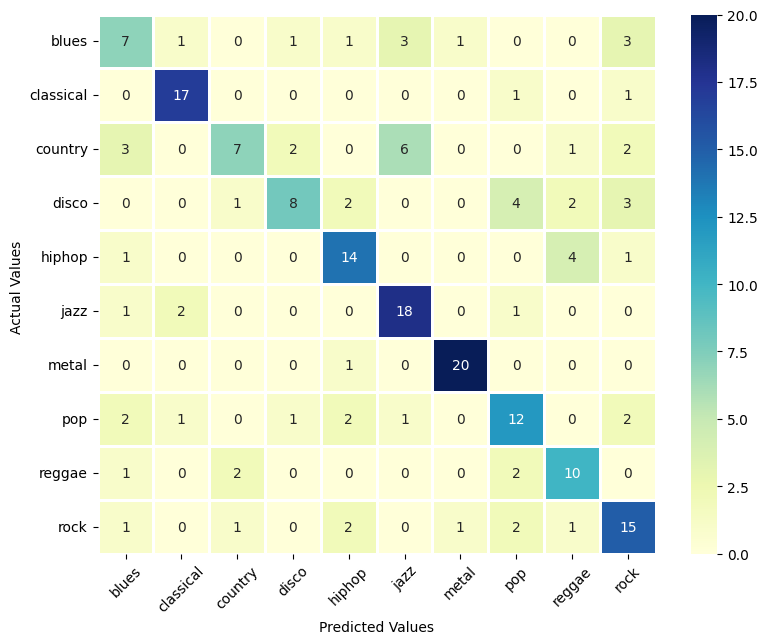

In [19]:
#fit first model with epochs=10 and plot results
epochs = 10
model_fit,model_history=create_fit_cnn(epochs)
print_accuracy(model_history)
plot_modelAccuracy(model_history)
plot_modelLoss(model_history)
cf_matrix=calculate_confusion_matrix(model_fit)
plot_confusion_matrix(cf_matrix)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 32)       

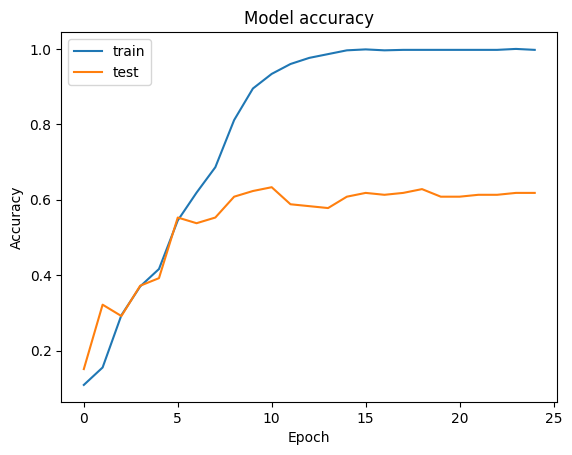

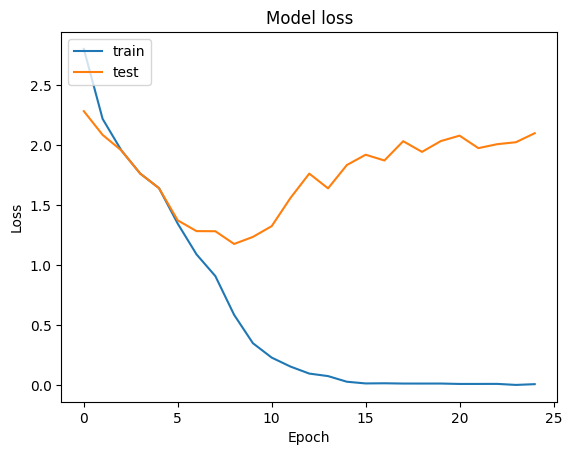

[[11  0  0  1  1  1  1  0  0  2]
 [ 0 16  1  0  0  0  0  1  0  1]
 [ 1  0 13  0  0  3  0  0  1  3]
 [ 1  0  1  8  2  0  0  5  2  1]
 [ 0  0  0  1 16  1  0  0  1  1]
 [ 1  3  0  0  0 15  1  0  1  1]
 [ 0  0  0  0  0  0 20  0  0  1]
 [ 0  0  1  0  2  0  0 13  2  3]
 [ 3  0  3  0  2  0  0  0  7  0]
 [ 3  0  5  2  1  0  5  1  2  4]]


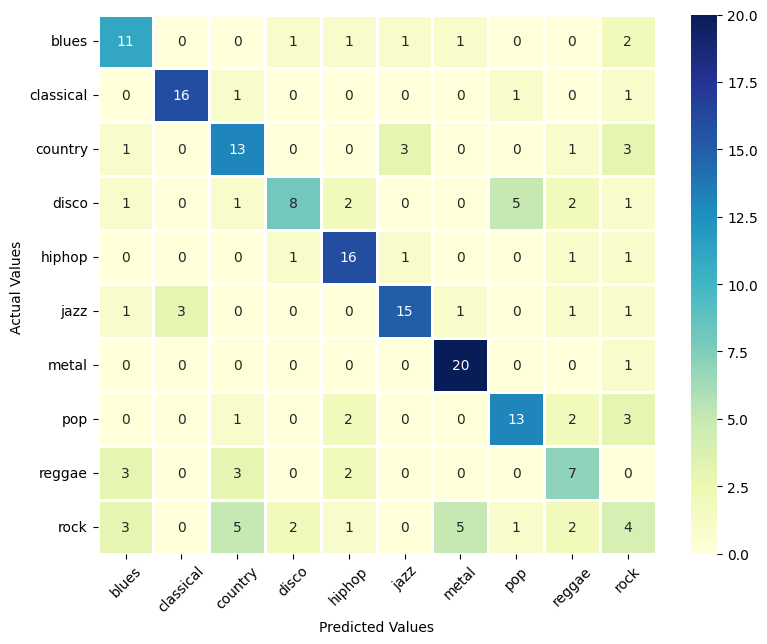

In [20]:
#fit first model with epochs=25 and plot results
epochs = 25
model_fit,model_history=create_fit_cnn(epochs)
print_accuracy(model_history)
plot_modelAccuracy(model_history)
plot_modelLoss(model_history)
cf_matrix=calculate_confusion_matrix(model_fit)
plot_confusion_matrix(cf_matrix)

In [21]:
#Function to create second dcnn model
def create_fit_cnn_02(prm_epochs):
    model = keras.Sequential(
        [
            keras.Input(shape=(256, 256, 3)),
            layers.Conv2D (16, kernel_size=(5, 5), activation="relu"),        
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.05),
            layers.Conv2D (32, kernel_size=(5, 5), activation="relu"),        
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.05),
            layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),        
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.05),
            layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),        
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.05),
            layers.Flatten(),
            layers.Dense(200, activation="relu"),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    print(model.summary())
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],)
    history = model.fit(data_train, epochs=prm_epochs, validation_data=data_test)
    return model,history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 126, 126, 16)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 32)      12832     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 61, 61, 32)       

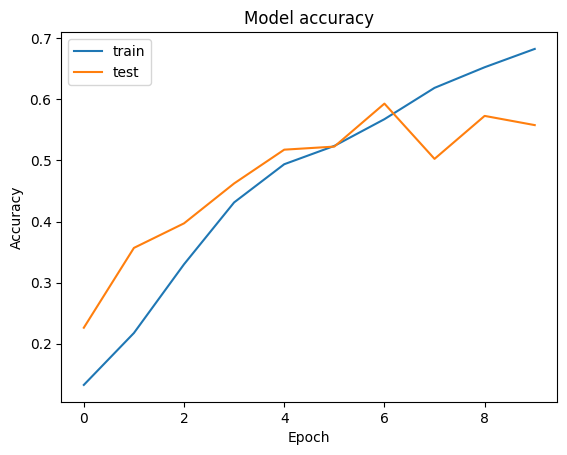

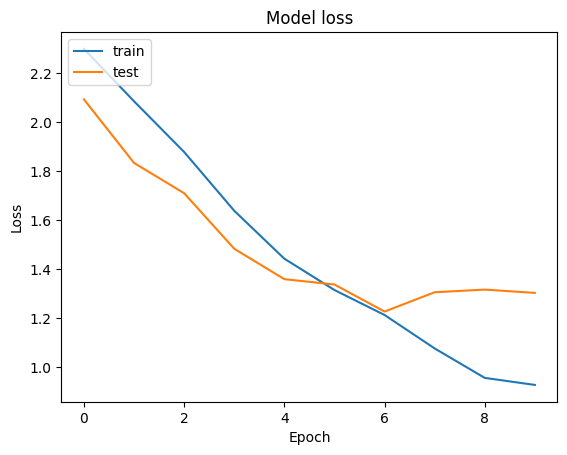

[[10  2  1  1  0  0  1  0  0  2]
 [ 2 14  0  1  0  1  0  1  0  0]
 [ 1  0 14  0  0  0  0  0  1  5]
 [ 0  0  4  4  1  0  2  4  1  4]
 [ 0  0  0  0 10  0  3  0  7  0]
 [ 1  2  2  0  0 14  0  0  1  2]
 [ 1  0  1  1  0  0 18  0  0  0]
 [ 1  2  1  1  3  0  0 11  1  1]
 [ 1  0  3  0  2  0  0  0  9  0]
 [ 2  0  6  2  1  0  4  1  0  7]]


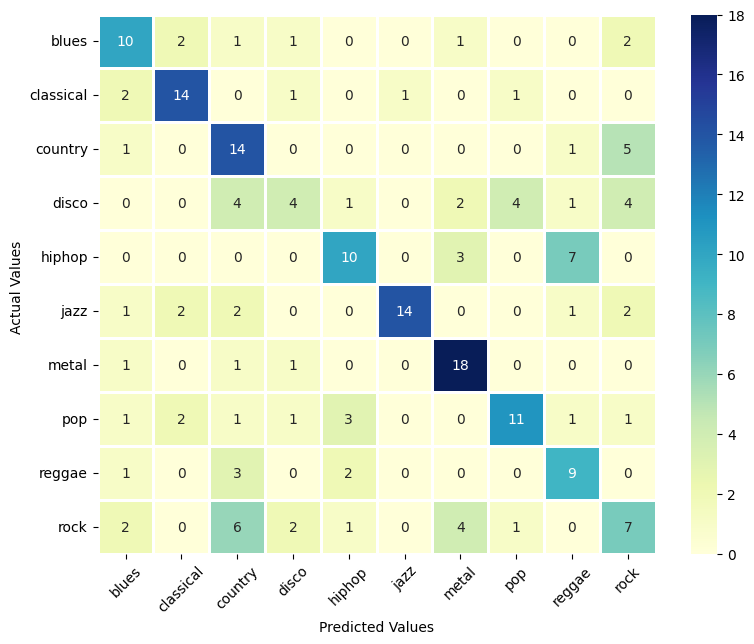

In [22]:
#fit second model with epochs=10 and plot results
epochs = 10
model_fit,model_history=create_fit_cnn_02(epochs)
print_accuracy(model_history)
plot_modelAccuracy(model_history)
plot_modelLoss(model_history)
cf_matrix=calculate_confusion_matrix(model_fit)
plot_confusion_matrix(cf_matrix)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 126, 126, 16)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 122, 122, 32)      12832     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 61, 61, 32)       

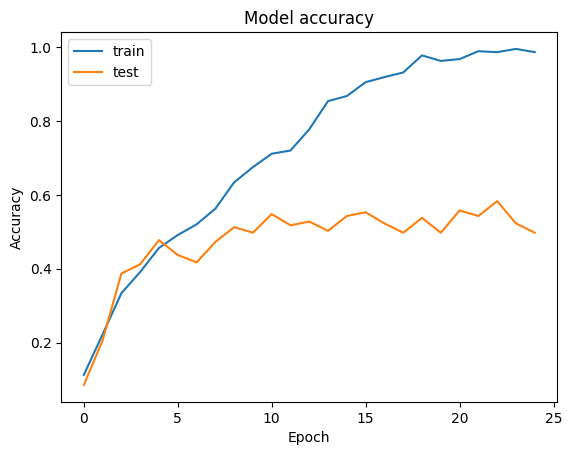

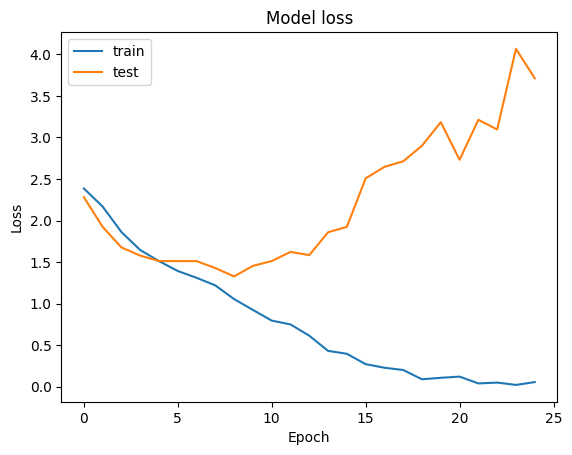

[[ 4  1  2  1  0  2  2  0  2  3]
 [ 0 14  1  0  0  1  0  1  0  2]
 [ 1  1 11  0  0  4  0  0  0  4]
 [ 0  0  2  3  2  0  1  2  5  5]
 [ 1  0  0  0 10  1  1  2  4  1]
 [ 1  2  2  0  0 15  1  1  0  0]
 [ 1  0  1  1  0  0 11  0  0  7]
 [ 0  1  1  0  1  2  0 11  3  2]
 [ 1  0  2  0  0  2  0  0  9  1]
 [ 1  0  6  1  0  1  0  0  3 11]]


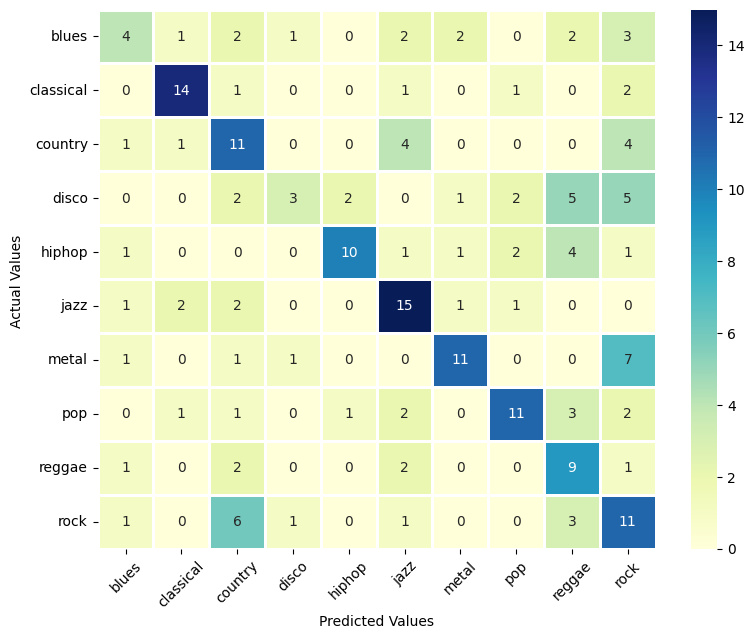

In [23]:
#fit second model with epochs=25 and plot results
epochs = 25
model_fit,model_history=create_fit_cnn_02(epochs)
print_accuracy(model_history)
plot_modelAccuracy(model_history)
plot_modelLoss(model_history)
cf_matrix=calculate_confusion_matrix(model_fit)
plot_confusion_matrix(cf_matrix)

In [24]:
                        ######################### END #########################